# Lecture 2 Exercise

In [142]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

## Trigram language Model

In [149]:
chars = sorted(list(set(''.join(words))))
chars.insert(0,'.')
len(chars)

27

In [150]:
stoi = {s:i for i, s in enumerate(chars)}
itos = {s:i for i, s in stoi.items()}


In [151]:
pairs = [(a,b) for a in chars for b in chars if b!="."]
pairs.insert(0, (".","."))
len(pairs)

703

In [42]:
ptoi = {pair: pos for pos, pair in enumerate(pairs)}
itop = {pos: pair for pair, pos in ptoi.items()}

In [44]:
import torch

# creating a 27 by 27 by 27 matrix to count all the number of occurence
N = torch.zeros((703,27),dtype = torch.int32)


In [60]:
# filling the count table with counts of each trigram
for word in words:
    chs = [".","."] + list(word) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        p1, p2 = ptoi[(ch1,ch2)], stoi[ch3]
        N[p1,p2] +=1

In [59]:
def get_occurences(char1, char2, char3):
    return N[ptoi[(char1, char2)], stoi[char3]]

In [155]:
get_occurences("a","d","i")

tensor(190, dtype=torch.int32)

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.figure(figsize=(20,20*20))
# plt.imshow(N, cmap = 'Blues')
# for i in range(703):
#     for j in range(27):
#         chstr = "".join(itop[i]) + itos[j]
#         plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'gray')
#         plt.text(j,i, N[i,j].item(), ha = 'center', va = 'top', color = 'gray')
# plt.axis('off')

In [87]:
N[0]

tensor([   0, 4411, 1306, 1542, 1690, 1532,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  395,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [103]:
P = (N+1).float() # smoothing
P /=  P.sum(1, keepdim = True)

In [117]:
g = torch.Generator().manual_seed(2147483647)


In [127]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    prev = ('.','.')
    out = []
    while True:
        idx = torch.multinomial(P[ptoi[prev]], num_samples = 1,replacement = True, generator = g).item()
        if idx == 0:
            break
        out.append(itos[idx])
        prev = (prev[1],itos[idx])
    print("".join(out))

junide
jakasid
prelay
adin
kairritoper
sathen
sameia
yanileniassibduinrwin
lessiyanayla
te


In [141]:
log_likelihood = 0.0
n = 0
for w in words:
    w = ["."] + ["."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(w,w[1:],w[2:]):
        ix1 = ptoi[(ch1,ch2)]
        ix2 = stoi[ch3]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1
        
        #print(f'{ch1}{ch2}{ch3}: {prob : .4f} {logprob: .4f}')
        
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'trigram average nll :{nll/n : .4f}')
print(f'bigram average nll: 2.4544')
        

log_likelihood=tensor(-504651.8750)
nll=tensor(504651.8750)
trigram average nll : 2.2120
bigram average nll: 2.4544


## Trigram Neural Network

In [162]:
# creating a training set of trigram
xs, ys = [],[]

for w in words[:1]:
    chs = [".","."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        p1, p2 = ptoi[(ch1,ch2)], stoi[ch3]
        print(ch1,ch2,ch3)
        xs.append(p1)
        ys.append(p2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. . e
. e m
e m m
m m a
m a .


In [163]:
xs

tensor([  0,   5, 143, 351, 339])

In [164]:
ys 

tensor([ 5, 13, 13,  1,  0])

In [166]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 703).float()
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [167]:
xenc.shape

torch.Size([5, 703])

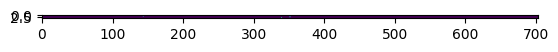

In [173]:

plt.imshow(xenc)

In [176]:
xenc.dtype

torch.float32

In [177]:
W = torch.randn(703,27)
xenc @ W

tensor([[-4.7530e-03,  8.5583e-02, -1.9633e+00,  2.7030e-01,  3.5163e-01,
          5.6949e-01, -3.5364e-01, -2.9256e-01, -1.2036e-01, -1.2206e+00,
         -6.5282e-01,  2.5050e+00, -5.4002e-02,  2.1959e+00,  9.0920e-01,
         -1.8809e-02, -2.4863e-01,  5.7408e-01,  3.0538e-01,  6.8942e-01,
          1.3405e-01,  6.5787e-03, -7.0764e-01, -7.3174e-01, -1.0403e+00,
          5.7320e-01, -3.1410e-01],
        [-6.2108e-02, -3.4693e-01,  1.0509e+00,  1.1220e+00, -1.6754e+00,
          5.6448e-01, -1.2730e+00,  6.8594e-01, -8.1767e-01,  1.8345e+00,
          7.5463e-01,  1.2477e+00, -4.5515e-01,  1.4485e-01,  1.5157e+00,
          1.4976e+00, -2.1860e-01, -7.0426e-01, -7.2626e-01,  8.9760e-01,
          1.3014e+00, -2.5798e+00,  7.1320e-01, -6.1954e-02, -1.2441e+00,
         -5.9263e-02,  4.9455e-01],
        [-3.0698e-01,  6.8603e-01, -1.5998e-01, -4.5555e-01,  1.2416e+00,
         -1.0530e+00,  5.1575e-01, -3.7056e-01,  2.0927e-01,  1.0154e+00,
          4.2884e-01,  5.0775e-01, -3.73

In [178]:
(xenc @ W).shape

torch.Size([5, 27])

In [179]:
(xenc @ W)[3,13]

tensor(-0.3277)

In [180]:
# randomly initialize 27 neurons weight, each neuron recieves 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((703,27), generator = g)

In [181]:
xenc = F.one_hot(xs, num_classes = 703).float() # input to the network : one_hot
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdim = True) # probabilities for next character
# btw: the last 2 line here together called a 'softmax'

In [183]:
probs.shape

torch.Size([5, 27])

In [184]:
probs[0].sum()

tensor(1.0000)

In [186]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print("----------")
    print(f'bigram example {i+1}: {"".join(itop[x])}{itos[y]} (indexes {x}, {y})')
    print('input to the neural net: ',x)
    print('output probabilities from the neural net:', probs[i])
    print("label (actual next character)", y)
    p = probs[i,y]
    print('probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll
    
print("========")
print('average negative log likelihood, i.e. loss = ', nll.mean().item())

----------
bigram example 1: ..e (indexes 0, 5)
input to the neural net:  0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character) 5
probability assigned by the net to the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
----------
bigram example 2: .em (indexes 5, 13)
input to the neural net:  5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character) 13
probability assigned by the net to the correct character: 0.

training the model on whole trigram

In [267]:
# creating the dataset

xs, ys = [],[]

for w in words:
    chs = [".","."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        p1, p2 = ptoi[(ch1,ch2)], stoi[ch3]
        xs.append(p1)
        ys.append(p2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
ns = xs.nelement()
print('number of examples: ', ns)



number of examples:  228146


In [268]:
# initialize the network
g = torch.Generator().manual_seed(2147483647)
xenc = F.one_hot(xs, num_classes = 703).float()
W = torch.randn((703,27), generator = g, requires_grad = True)


In [269]:
xenc.shape, W.shape

(torch.Size([228146, 703]), torch.Size([703, 27]))

In [270]:
# gradient descent 

for k in range(1000):
    # Forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim = True)
    loss = -probs[torch.arange(ns), ys].log().mean() + 0.01 * (W**2).mean()
    if k % 50 == 0:
        print(f"iteration{k} loss: {loss.item()}")
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -100 * W.grad

iteration0 loss: 3.8183300495147705
iteration50 loss: 2.5134758949279785
iteration100 loss: 2.387240171432495
iteration150 loss: 2.3350751399993896
iteration200 loss: 2.3063032627105713
iteration250 loss: 2.2881085872650146
iteration300 loss: 2.2755985260009766
iteration350 loss: 2.2664778232574463
iteration400 loss: 2.259530544281006
iteration450 loss: 2.254058599472046
iteration500 loss: 2.249636173248291
iteration550 loss: 2.2459895610809326
iteration600 loss: 2.2429332733154297
iteration650 loss: 2.2403371334075928
iteration700 loss: 2.238107204437256
iteration750 loss: 2.2361724376678467
iteration800 loss: 2.2344796657562256
iteration850 loss: 2.2329864501953125
iteration900 loss: 2.2316601276397705
iteration950 loss: 2.2304751873016357


In [271]:
loss.item()

2.2294304370880127

In [273]:
# sample from the 'neural net' model

g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    char1 = '.'
    char2 = '.'
    
    while True: 
        xenc = F.one_hot(torch.tensor([ptoi[(char1, char2)]]), num_classes = 703).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdim = True) # probabilities for next character
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        if ix == 0:
            break
        char1 = char2
        char2 = itos[ix]
        out.append(itos[ix])
        
    print(''.join(out))
        

junide
janasid
prelay
adin
kairritoper
sathen
sameia
yanileniassibduinewin
lessiyanayla
te


 ## E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [321]:
xenc = F.one_hot(xs, num_classes = 703).float()
xenc.shape, ys.shape

(torch.Size([228146, 703]), torch.Size([228146]))

In [322]:
# split the dataset into train, validation and test set
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(xenc.shape[0]), [0.8,0.1,0.1])

xs_train , ys_train = xenc[train_idx], ys[train_idx]
xs_val , ys_val = xenc[val_idx], ys[val_idx]
xs_test, ys_test = xenc[test_idx], ys[test_idx]

print(xs_train.shape, ys_train.shape)
print(xs_val.shape, ys_val.shape)
print(xs_test.shape, ys_test.shape)

torch.Size([182517, 703]) torch.Size([182517])
torch.Size([22815, 703]) torch.Size([22815])
torch.Size([22814, 703]) torch.Size([22814])


In [323]:
# new weights 
W = torch.rand((703,27), requires_grad = True)
R = 0.001 # regularization

In [326]:
def forward_pass(inputs, weights):
    # perform matrix multiplication between inputs and weights
    logits = inputs @ weights
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim = True)
    return p

def nll_loss(p, n_inputs, labels, lbd = 0.01):
    # calculate the negative log likelihood and apply model smoothing with regularizatin
    nll  = -p[torch.arange(n_inputs), labels].log().mean() + lbd * (W**2).mean()
    return nll

In [327]:
# train the model

for i in range(1001):
    probs = forward_pass(xs_train, W)
    loss = nll_loss(probs, xs_train.shape[0], ys_train)
    if i %100 == 0:
        val_probs = forward_pass(xs_val, W)
        val_loss = nll_loss(val_probs, xs_val.shape[0], ys_val)
        print(f'interation {i}, train-loss {loss.item():.4f}, \t val-loss{val_loss:.4f}')
        
    # backward_pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

interation 0, train-loss 2.4068, 	 val-loss2.4227
interation 100, train-loss 2.3230, 	 val-loss2.3424
interation 200, train-loss 2.2902, 	 val-loss2.3117
interation 300, train-loss 2.2717, 	 val-loss2.2946
interation 400, train-loss 2.2596, 	 val-loss2.2838
interation 500, train-loss 2.2511, 	 val-loss2.2764
interation 600, train-loss 2.2448, 	 val-loss2.2710
interation 700, train-loss 2.2399, 	 val-loss2.2669
interation 800, train-loss 2.2360, 	 val-loss2.2637
interation 900, train-loss 2.2328, 	 val-loss2.2611
interation 1000, train-loss 2.2302, 	 val-loss2.2590


In [328]:
# loss on the test set

test_loss = nll_loss(forward_pass(xs_test,W), xs_test.shape[0], ys_test)
print(f"loss on test is {test_loss:.4f}")

loss on test is 2.2576


Loss on the validation set and test set in slightly highter than the train set.

## E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [329]:
import pandas as pd

d = {}

for i in [1,0.5,0.1,0.05, 0.007, 0.0005, 0.0001,0.00001,0.0000]:
    val_prob = forward_pass(xs_val, W)
    val_loss = -val_prob[torch.arange(xs_val.shape[0]),ys_val].log().mean() + i * (W**2).mean()
    d[i] = val_loss.item()

In [330]:
d

{1: 3.0314645767211914,
 0.5: 2.6413421630859375,
 0.1: 2.329244375228882,
 0.05: 2.2902321815490723,
 0.007: 2.2566816806793213,
 0.0005: 2.251610040664673,
 0.0001: 2.251297950744629,
 1e-05: 2.251227855682373,
 0.0: 2.2512199878692627}

model works best without any regularization

In [331]:
# loss on the test set

test_loss = nll_loss(forward_pass(xs_test,W), xs_test.shape[0], ys_test,0.0)
print(f"loss on test is {test_loss:.4f}")

loss on test is 2.2498


## E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [335]:
train_idx, val_idx = torch.utils.data.random_split(range(xs.shape[0]),[0.8,0.2])

xs_train, ys_train = xs[train_idx], ys[train_idx]
xs_val, ys_val = xs[val_idx], ys[val_idx]

print(xs_train.shape, ys_train.shape)
print(xs_val.shape, ys_val.shape)

torch.Size([182517]) torch.Size([182517])
torch.Size([45629]) torch.Size([45629])


In [336]:
def forward_pass(inputs, weights):
    # perform matrix multiplication between inputs and weights
    #logits = inputs @ weights
    logits = weights[inputs] # inputs consists of indexs
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim = True)
    return p

def nll_loss(p, n_inputs, labels, lbd = 0.01):
    # calculate the negative log likelihood and apply model smoothing with regularizatin
    nll  = -p[torch.arange(n_inputs), labels].log().mean() + lbd * (W**2).mean()
    return nll

In [337]:
# train the model

for i in range(1001):
    probs = forward_pass(xs_train, W)
    loss = nll_loss(probs, xs_train.shape[0], ys_train,0.0)
    if i %100 == 0:
        val_probs = forward_pass(xs_val, W)
        val_loss = nll_loss(val_probs, xs_val.shape[0], ys_val,0.0)
        print(f'interation {i}, train-loss {loss.item():.4f}, \t val-loss{val_loss:.4f}')
        
    # backward_pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

interation 0, train-loss 2.2268, 	 val-loss2.2329
interation 100, train-loss 2.2217, 	 val-loss2.2364
interation 200, train-loss 2.2186, 	 val-loss2.2368
interation 300, train-loss 2.2161, 	 val-loss2.2367
interation 400, train-loss 2.2140, 	 val-loss2.2365
interation 500, train-loss 2.2122, 	 val-loss2.2361
interation 600, train-loss 2.2106, 	 val-loss2.2358
interation 700, train-loss 2.2091, 	 val-loss2.2354
interation 800, train-loss 2.2078, 	 val-loss2.2351
interation 900, train-loss 2.2067, 	 val-loss2.2347
interation 1000, train-loss 2.2056, 	 val-loss2.2344


## E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [338]:
W = torch.rand((703,27), requires_grad = True)


In [339]:
for i in range(1001):
    logits = W[xs_train]
    loss = F.cross_entropy(logits, ys_train, label_smoothing = 0.001)
    if i %100 == 0:
        val_logits = W[xs_val]
        val_loss = F.cross_entropy(val_logits, ys_val, label_smoothing = 0.001)
        print(f'interation {i}, train-loss {loss.item():.4f}, \t val-loss{val_loss:.4f}')
        
    # backward_pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

interation 0, train-loss 3.3427, 	 val-loss3.3423
interation 100, train-loss 2.4252, 	 val-loss2.4453
interation 200, train-loss 2.3348, 	 val-loss2.3575
interation 300, train-loss 2.2960, 	 val-loss2.3202
interation 400, train-loss 2.2740, 	 val-loss2.2994
interation 500, train-loss 2.2596, 	 val-loss2.2861
interation 600, train-loss 2.2495, 	 val-loss2.2769
interation 700, train-loss 2.2419, 	 val-loss2.2702
interation 800, train-loss 2.2361, 	 val-loss2.2650
interation 900, train-loss 2.2314, 	 val-loss2.2610
interation 1000, train-loss 2.2275, 	 val-loss2.2578


## E06: meta-exercise! Think of a fun/interesting exercise and complete it.

Train the trigram model on half of the dataset using the loss cross_entropy and check the prediction


In [341]:
half_idx , val_idx = torch.utils.data.random_split(range(xs.shape[0]),[0.5,0.5])

xs_half = xs[half_idx]
ys_half = ys[half_idx]

In [343]:
xs_half.shape, ys_half.shape

(torch.Size([114073]), torch.Size([114073]))

In [344]:
W = torch.rand((703,27), requires_grad = True)

In [345]:
for i in range(1001):
    logits = W[xs_train]
    loss = F.cross_entropy(logits, ys_train, label_smoothing = 0.001)
    if i %100 == 0:
        print(f'interation {i}, loss {loss.item():.4f}')
        
    # backward_pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

interation 0, loss 3.3330
interation 100, loss 2.4295
interation 200, loss 2.3371
interation 300, loss 2.2975
interation 400, loss 2.2750
interation 500, loss 2.2604
interation 600, loss 2.2501
interation 700, loss 2.2424
interation 800, loss 2.2365
interation 900, loss 2.2317
interation 1000, loss 2.2278


In [346]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    char1 = '.'
    char2 = '.'
    
    while True: 
        logits = W[ptoi[char1, char2]]
        p = F.softmax(logits, dim = 0) # probabilities for next character
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        if ix == 0:
            break
        char1 = char2
        char2 = itos[ix]
        out.append(itos[ix])
        
    print(''.join(out))

junide
janasid
prelay
adin
kairritonian
juwa
kalania
zabileniassibduinrwin
lessiyanayla
te
